In [9]:
## %%writefile Lagrange_1D.py
## Convertit la fonction définie ici dans un scipt Python

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

def Lagrange_1D(pb, flx_type, nc, cfl, vplt):
    if vplt == 1:
        plt.close('all')

    if pb == 1:
        xd, xf, xdis = 0, 1, 0.5
        gam, tfin = 1.4, 0.2
        den_L, pre_L, vit_L = 1, 1, 0
        den_R, pre_R, vit_R = 0.125, 0.1, 0
    elif pb == 2:
        xd, xf, xdis = 0, 1, 0.5
        gam, tfin = 1.4, 0.15
        den_L, pre_L, vit_L = 1, 0.4, -2
        den_R, pre_R, vit_R = 1, 0.4, 2

    dx = (xf - xd) / nc
    xint = np.linspace(xd, xf, nc + 1)
    xi = np.arange(xd + dx / 2, xf - dx / 2 + dx / 2, dx)

    den = np.zeros(nc)
    vit = np.zeros(nc)
    pre = np.zeros(nc)
    ene = np.zeros(nc)
    cel = np.zeros(nc)
    masse = np.zeros(nc)
    Vsol = np.zeros((nc, 3))
    
    for ii in range(nc):
        if xint[ii + 1] <= xdis:
            den[ii], pre[ii], vit[ii] = den_L, pre_L, vit_L
        else:
            den[ii], pre[ii], vit[ii] = den_R, pre_R, vit_R
        
        ene[ii] = pre[ii] / (den[ii] * (gam - 1)) + vit[ii] ** 2 / 2
        cel[ii] = np.sqrt(pre[ii] * gam / den[ii])
        masse[ii] = den[ii] * dx

        Vsol[ii, 0] = 1 / den[ii]
        Vsol[ii, 1] = vit[ii]
        Vsol[ii, 2] = ene[ii]

    tps = 0
    flux_int = np.zeros((nc + 1, 3))
    n_it = 0

    while tps < tfin:
        dt = cfl * np.min(masse) / np.max(den * cel)
        if tps + dt > tfin + 1e-6:
            dt = tfin - tps
        
        flux_int[0, :] = flux_num(Vsol[0, :], Vsol[0, :], gam, flx_type)
        xint[0] -= dt * flux_int[0, 0]
        
        for ii in range(nc):
            if ii < nc - 1:
                flux_int[ii + 1, :] = flux_num(Vsol[ii, :], Vsol[ii + 1, :], gam, flx_type)
            else:
                flux_int[ii + 1, :] = flux_num(Vsol[ii, :], Vsol[ii, :], gam, flx_type)
            
            Vsol[ii, :] -= dt / masse[ii] * (flux_int[ii + 1, :] - flux_int[ii, :])
            xint[ii + 1] -= dt * flux_int[ii + 1, 0]
            xi[ii] = (xint[ii] + xint[ii + 1]) / 2
            
            den[ii] = 1 / Vsol[ii, 0]
            vit[ii] = Vsol[ii, 1]
            pre[ii] = den[ii] * (gam - 1) * (Vsol[ii, 2] - 0.5 * vit[ii] ** 2)
            cel[ii] = np.sqrt(pre[ii] * gam / den[ii])

        tps += dt
        n_it += 1

    if pb == 1:
        file_den_sol = 'Sol_exactes/sod_den.dat'
        file_eni_sol = 'Sol_exactes/sod_eni.dat'
    elif pb == 2:
        file_den_sol = 'Sol_exactes/dbl_det_den.dat'
        file_eni_sol = 'Sol_exactes/dbl_det_eni.dat'

    with open(file_den_sol, 'r') as fid_den, open(file_eni_sol, 'r') as fid_eni:
        TT = fid_den.read()
        ss = sum(c == '\n' for c in TT)
        fid_den.seek(0)
        
        xs = np.zeros(ss)
        den_sol = np.zeros(ss)
        eni_sol = np.zeros(ss)
        
        for ii in range(ss):
            a_den = np.array([float(val) for val in fid_den.readline().split()])
            a_eni = np.array([float(val) for val in fid_eni.readline().split()])
            
            xs[ii] = a_den[0]
            den_sol[ii] = a_den[1]
            eni_sol[ii] = a_eni[1]

    if vplt == 1:
        plt.figure(1, figsize=(10, 8))
        plt.plot(xs, den_sol, '-r', linewidth=3)
        plt.plot(xi, den, '-db')
        plt.xlabel('x')
        plt.ylabel('densité')
        plt.title("Densité à l'instant final")
        plt.legend(['solution exacte', 'schéma Lagrangien'], loc='upper right')

        plt.figure(2, figsize=(10, 8))
        plt.plot(xs, eni_sol, '-r', linewidth=3)
        plt.plot(xi, pre / ((gam - 1) * den), '-db')
        plt.xlabel('x')
        plt.ylabel('énergie interne')
        plt.title("Énergie interne à l'instant final")
        plt.legend(['solution exacte', 'schéma Lagrangien'], loc='upper left')
    else:
        return xs,den_sol,eni_sol,xi,den,pre / ((gam - 1) * den)

    plt.show()


def flux_num(VL, VR, gam, flx_type):
    den_L = 1 / VL[0]
    vit_L = VL[1]
    ene_L = VL[2]
    pre_L = den_L * (gam - 1) * (VL[2] - 0.5 * VL[1] ** 2)
    cel_L = np.sqrt(pre_L * gam / den_L)

    den_R = 1 / VR[0]
    vit_R = VR[1]
    ene_R = VR[2]
    pre_R = den_R * (gam - 1) * (VR[2] - 0.5 * VR[1] ** 2)
    cel_R = np.sqrt(pre_R * gam / den_R)

    if flx_type == 1:
        Z0 = max(den_L * cel_L, den_R * cel_R)
        vit_riemann = 0.5 * (vit_L + vit_R + Z0 * (1 / den_R - 1 / den_L))
        pre_riemann = 0.5 * (pre_L + pre_R - Z0 * (vit_R - vit_L))
        pre_vit_riemann = 0.5 * (pre_L * vit_L + pre_R * vit_R - Z0 * (ene_R - ene_L))
    elif flx_type == 2:
        Z0 = max(den_L * cel_L, den_R * cel_R)
        vit_riemann = 0.5 * (vit_L + vit_R - (pre_R - pre_L) / Z0)
        pre_riemann = 0.5 * (pre_L + pre_R - Z0 * (vit_R - vit_L))
        pre_vit_riemann = pre_riemann * vit_riemann
    else:
        ZL = den_L * cel_L
        ZR = den_R * cel_R
        vit_riemann = (ZL * vit_L + ZR * vit_R - (pre_R - pre_L)) / (ZL + ZR)
        pre_riemann = (ZR * pre_L + ZL * pre_R - ZL * ZR * (vit_R - vit_L)) / (ZL + ZR)
        pre_vit_riemann = pre_riemann * vit_riemann
    
    return [-vit_riemann, pre_riemann, pre_vit_riemann]


## Voici un exemple de comment appeler la funtion
## Lagrange_1D(1, 3, 100, 0.9, 1)


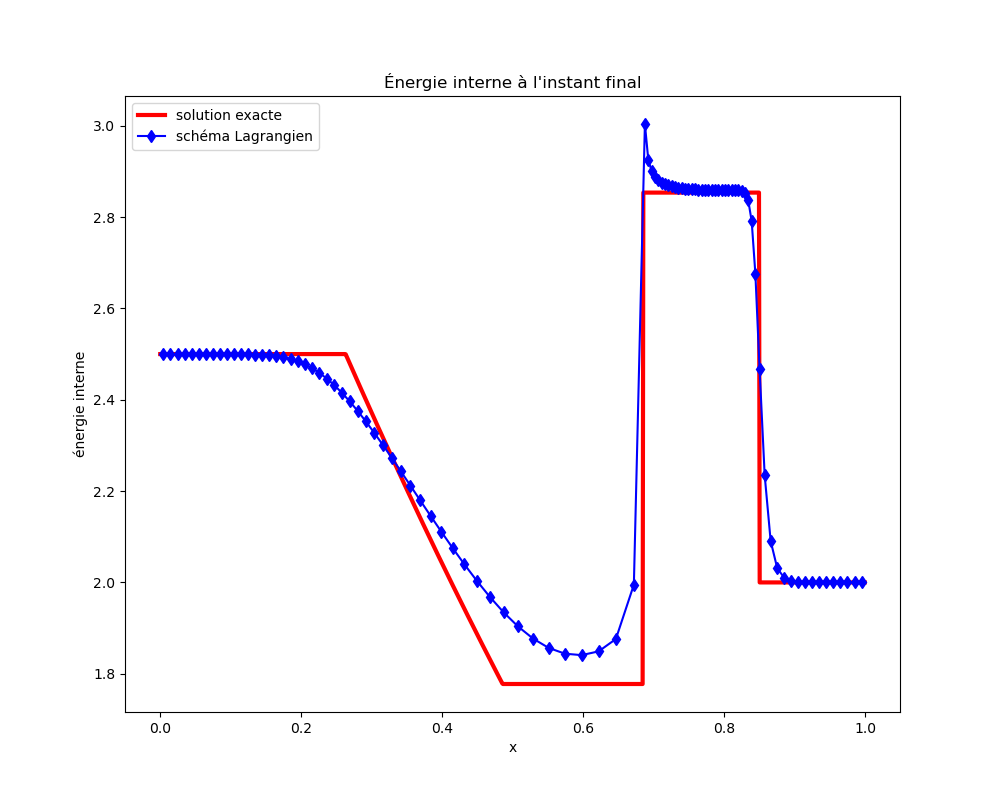

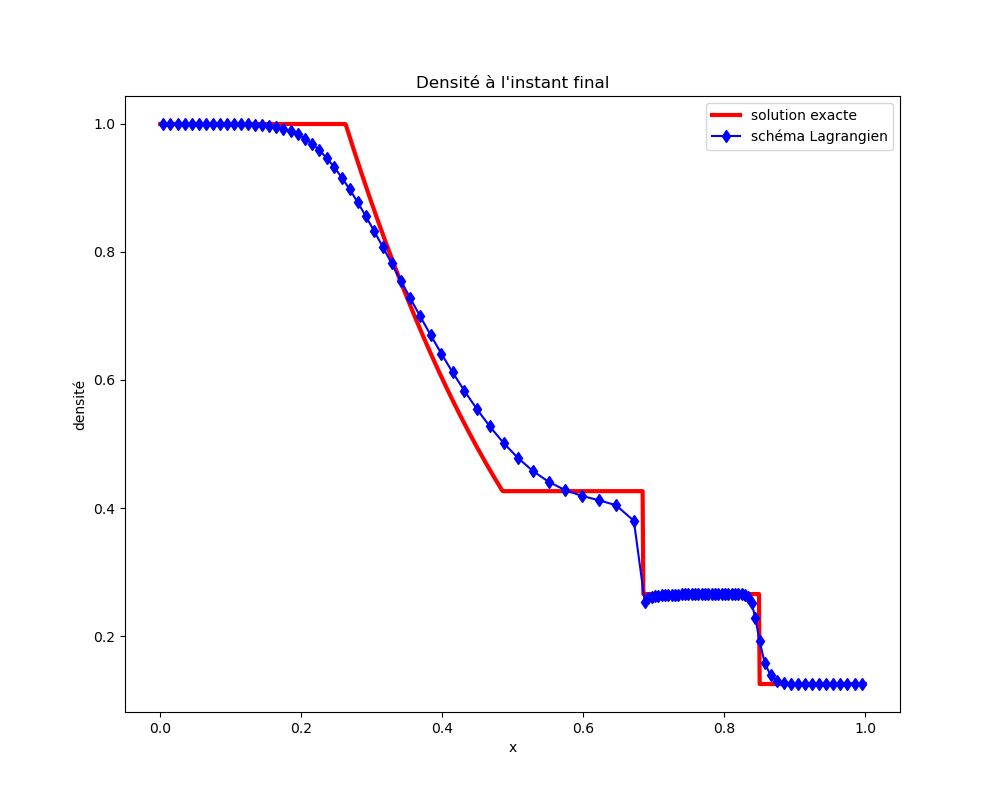

In [10]:
Lagrange_1D(1, 3, 100, 0.9, 1)